In [49]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sweetviz as sv
import category_encoders as ce
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import FastICA
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [50]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [51]:
heart_dis_pred = pd.read_csv("heart_cleaned_encoded.csv")

In [52]:
features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory_0', 'AgeCategory_1', 'AgeCategory_2', 'AgeCategory_3', 'Race_0', 'Race_1', 'Race_2', 'GenHealth_0', 'GenHealth_1', 'GenHealth_2', 'SleepTime', 'Smoking_No', 'AlcoholDrinking_No', 'Stroke_No', 'DiffWalking_No', 'Sex_Female', 'Diabetic_No', 'KidneyDisease_No', 'SkinCancer_No', 'PhysicalActivity_Yes', 'Asthma_No']
# Separating out the features
x = heart_dis_pred.loc[:, features].values
# Separating out the target
y = heart_dis_pred.loc[:,['HeartDisease_No']].values

colors = ['red', 'green', 'blue', 'orange', 'yellow', 'indigo', 'violet', 'Pink', 'Purple', 
          'Turquoise', 'Gold', 'Lime', 'Maroon', 'Navy', 'Coral', 'Teal', 'Brown' ,'Black', 'Pink', 'rosybrown', 'Grey', 'darkkhaki'
             , 'Silver', 'darkolivegreen', 'black']

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns = features)
standard_df = pd.concat([standard_df, heart_dis_pred.loc[:,['HeartDisease_No']]], axis=1)

# fig, ax1 = plt.subplots(ncols = 1, figsize =(20, 10))
# for column, color in zip(features, colors):
#     sns.kdeplot(standard_df[column], ax = ax1, color = color)
# ax1.set_title('After Standard Scaling')
# plt.show()

In [53]:
heart_dis_pred = standard_df
# print(heart_dis_pred.head(5))
# print(heart_dis_pred.shape)

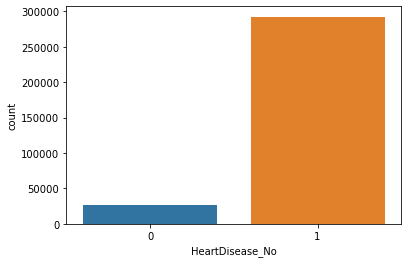

In [54]:
status_plot = sns.countplot(x ='HeartDisease_No', data = heart_dis_pred)

<AxesSubplot:title={'center':'Verify that class distributuion in train is same as input data'}, xlabel='HeartDisease_No'>

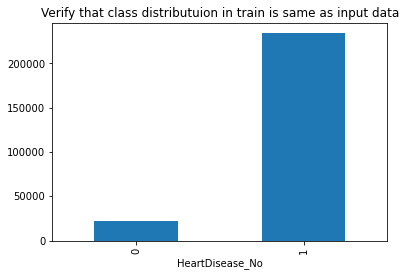

In [55]:
train, test = train_test_split(heart_dis_pred, test_size = 0.2, stratify=heart_dis_pred['HeartDisease_No'])
train.pivot_table(index='HeartDisease_No', aggfunc='size').plot(kind='bar', title='Verify that class distributuion in train is same as input data')

<AxesSubplot:title={'center':'Verify that class distributuion in test is same as input data'}, xlabel='HeartDisease_No'>

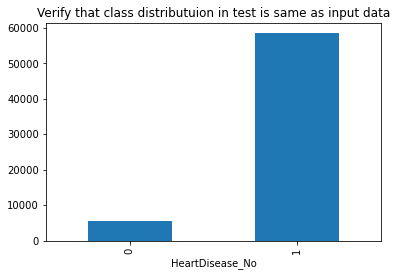

In [56]:
test.pivot_table(index='HeartDisease_No', aggfunc='size').plot(kind='bar', title='Verify that class distributuion in test is same as input data')

# Logistic Regression with Scaling

In [57]:
%%time
# Instantiate the Logistic Regression with only default settings
my_log_reg = LogisticRegression()

# Fit the logistic regression on the independent variables of the train data with buy as dependent variable
my_log_reg.fit(train[features], train['HeartDisease_No'])



Wall time: 1.63 s


LogisticRegression()

In [58]:
# Make a prediction using our model on the test set
preds = my_log_reg.predict(test[features])

In [59]:
pkl.dump(my_log_reg, open('model_lr.pkl', 'wb'))

In [60]:
tn, fp, fn, tp = confusion_matrix(test['HeartDisease_No'], preds).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  580 
False positives:  4895 
False negatives:  537 
True Positives:  57947


In [61]:
print(classification_report(test['HeartDisease_No'], preds))

              precision    recall  f1-score   support

           0       0.52      0.11      0.18      5475
           1       0.92      0.99      0.96     58484

    accuracy                           0.92     63959
   macro avg       0.72      0.55      0.57     63959
weighted avg       0.89      0.92      0.89     63959



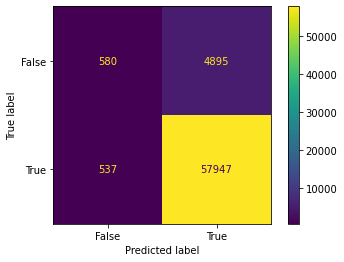

In [62]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test['HeartDisease_No'], preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [63]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(test, label='HeartDisease_No'), my_log_reg)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 20 categorical features were inferred.: AgeCategory_0, AgeCategory_1, AgeCategory_2, AgeCategory_3, Race_0, Race_1, Race_2... For full list use dataset.cat_features


# Logistic Regression with Scaling + SMOTE

In [64]:
X_resampled, y_resampled = SMOTE().fit_resample(train[features], train['HeartDisease_No'])
print(X_resampled.shape)
train[features].shape

(467876, 24)


(255836, 24)

In [65]:
features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory_0', 'AgeCategory_1', 'AgeCategory_2', 'AgeCategory_3', 'Race_0', 'Race_1', 'Race_2', 'GenHealth_0', 'GenHealth_1', 'GenHealth_2', 'SleepTime', 'Smoking_No', 'AlcoholDrinking_No', 'Stroke_No', 'DiffWalking_No', 'Sex_Female', 'Diabetic_No', 'KidneyDisease_No', 'SkinCancer_No', 'PhysicalActivity_Yes', 'Asthma_No']
tempDf1 = pd.DataFrame(data = X_resampled, columns = features )
tempDf2 =  y_resampled.to_frame(name='HeartDisease_No')
smote_df = pd.concat([tempDf1, tempDf2], axis = 1)
print(smote_df.shape)
smote_df.to_csv("heart_cleaned_encoded_smote.csv")

(467876, 25)


<AxesSubplot:title={'center':'Class distribution after appying SMOTE'}, xlabel='HeartDisease_No'>

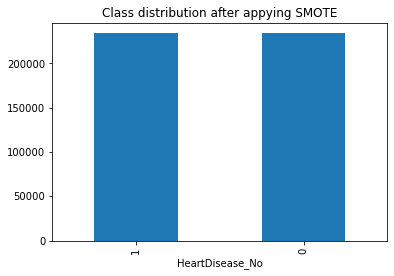

In [66]:
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='HeartDisease_No')

In [67]:
%%time
from timeit import default_timer as timer
# Instantiate the new Logistic Regression
log_reg_2 = LogisticRegression(random_state = 2022)
start = timer()
# Fit the model with the data that has been resampled with SMOTE
log_reg_2.fit(X_resampled, y_resampled)
train_patched = timer() - start
f"Scikit-learn time: {train_patched:.2f} s"

Wall time: 1.52 s


'Scikit-learn time: 1.52 s'

In [68]:
# Predict on the test set (not resampled to obtain honest evaluation)
preds2 = log_reg_2.predict(test[features])

In [69]:
pkl.dump(log_reg_2, open('model_lr_smote.pkl', 'wb'))

In [70]:
tn, fp, fn, tp = metrics.confusion_matrix(test['HeartDisease_No'], preds2).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  4127 
False positives:  1348 
False negatives:  14235 
True positives:  44249


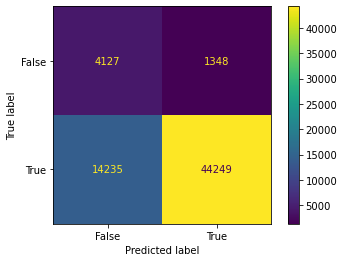

In [71]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test['HeartDisease_No'], preds2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [72]:
print(classification_report(test['HeartDisease_No'], preds2))

              precision    recall  f1-score   support

           0       0.22      0.75      0.35      5475
           1       0.97      0.76      0.85     58484

    accuracy                           0.76     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.76      0.81     63959



In [73]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(test, label='HeartDisease_No'), log_reg_2)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 20 categorical features were inferred.: AgeCategory_0, AgeCategory_1, AgeCategory_2, AgeCategory_3, Race_0, Race_1, Race_2... For full list use dataset.cat_features


In [79]:
from deepchecks.tabular.suites import full_suite
from deepchecks import Dataset

tempDf = pd.concat([X_resampled, y_resampled], axis=1)
train_ds1 = Dataset(tempDf, label="HeartDisease_No", cat_features=[])
test_ds1 = Dataset(test, label="HeartDisease_No", cat_features=[])
print(tempDf.head(5))
print(test.head(5))

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead



        BMI  PhysicalHealth  MentalHealth  AgeCategory_0  AgeCategory_1  \
0 -0.167619        0.079022     -0.490039       1.252493      -0.899057   
1  0.143894       -0.424070      1.395515       1.252493      -0.899057   
2  0.101415       -0.424070     -0.490039      -0.798408       1.112276   
3 -0.616007       -0.424070     -0.490039      -0.798408      -0.899057   
4 -0.394173       -0.424070     -0.490039       1.252493      -0.899057   

   AgeCategory_2  AgeCategory_3    Race_0    Race_1    Race_2  GenHealth_0  \
0       0.970591      -1.119679 -0.397189 -0.472932  0.458684    -0.568599   
1      -1.030300      -1.119679  2.517695 -0.472932  0.458684    -0.568599   
2      -1.030300       0.893113  2.517695  2.114468 -2.180150    -0.568599   
3       0.970591       0.893113 -0.397189 -0.472932  0.458684     1.758710   
4      -1.030300      -1.119679 -0.397189 -0.472932  0.458684     1.758710   

   GenHealth_1  GenHealth_2  SleepTime  Smoking_No  AlcoholDrinking_No  \
0    -

In [80]:
suite = full_suite()
result = suite.run(train_ds1, test_ds1, log_reg_2)
result.save_as_html("Full Suite")

'Full Suite.html'

#                Testing for overfitting

In [84]:
X_resampled = X_resampled.head(1000)
y_resampled = y_resampled.head(1000)
tempDf = pd.concat([X_resampled, y_resampled], axis=1)
train_ds1 = Dataset(tempDf, label="HeartDisease_No", cat_features=[])
test_ds1 = Dataset(test, label="HeartDisease_No", cat_features=[])

In [86]:
%%time
from timeit import default_timer as timer
# Instantiate the new Logistic Regression
log_reg_2 = LogisticRegression(random_state = 2022)
start = timer()
# Fit the model with the data that has been resampled with SMOTE
log_reg_2.fit(X_resampled, y_resampled)
train_patched = timer() - start
f"Scikit-learn time: {train_patched:.2f} s"

Wall time: 16 ms


'Scikit-learn time: 0.02 s'

In [83]:
suite = full_suite()
result = suite.run(train_dataset=train_ds1, test_dataset=test_ds1, model=log_reg_2)
result.save_as_html("Full_Suite_1000")

'Full_Suite_1000.html'

# Logistic Regression with Scaling + SMOTE + PCA

In [ ]:
pca = PCA(n_components = 0.95)
pca.fit(X_resampled)
reduced = pca.transform(X_resampled)
print("\n n_components_--->",pca.n_components_)
principalTrainDf = pd.DataFrame(data = reduced, columns = ['principal component 1','principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13','principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19','principal component 20'])
finalTrainDf = pd.concat([principalTrainDf, y_resampled], axis = 1)
print("\n explained_variance_ratio_--->",pca.explained_variance_ratio_)
finalTrainDf.to_csv("heart_cleaned_encoded_trained_pca.csv")


testTargetVars = pd.DataFrame()
testTargetVars['HeartDisease_No'] = test['HeartDisease_No'].values
pcaTest = test.drop(['HeartDisease_No'], axis=1)
reduced = pca.transform(pcaTest)
print("\n n_components_--->",pca.n_components_)
principalTestDf = pd.DataFrame(data = reduced, columns = ['principal component 1','principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13','principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19','principal component 20'])
finalTestDf = pd.concat([principalTestDf, testTargetVars], axis = 1)
print("\n explained_variance_ratio_--->",pca.explained_variance_ratio_)
finalTestDf.to_csv("heart_cleaned_encoded_tested_pca.csv")

In [ ]:
%%time
features = ['principal component 1','principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13','principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19','principal component 20']

# Instantiate the Logistic Regression with only default settings
my_log_reg = LogisticRegression()

# Fit the logistic regression on the independent variables of the train data with buy as dependent variable
my_log_reg.fit(finalTrainDf[features], finalTrainDf['HeartDisease_No'])

In [ ]:
# Make a prediction using our model on the test set
preds = my_log_reg.predict(finalTestDf[features])

In [ ]:
pkl.dump(my_log_reg, open('model_lr_pca.pkl', 'wb'))

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(finalTestDf['HeartDisease_No'], preds).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

In [ ]:
print(classification_report(finalTestDf['HeartDisease_No'], preds))

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(finalTestDf['HeartDisease_No'], preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(finalTestDf, label='HeartDisease_No'), my_log_reg)

# Logistic Regression with Scaling + SMOTE + ICA

In [ ]:
# Creating ICA object
ica = FastICA(n_components=20)
independentComponentValues=ica.fit_transform(X_resampled)
#Creating the dataframe
reducedData=pd.DataFrame(data=independentComponentValues, columns=['independent component 1','independent component 2','independent component 3','independent component 4','independent component 5','independent component 6','independent component 7','independent component 8','independent component 9','independent component 10','independent component 11','independent component 12','independent component 13','independent component 14','independent component 15','independent component 16','independent component 17','independent component 18','independent component 19','independent component 20'])
finalTrainDf = pd.concat([reducedData, y_resampled], axis = 1)
# print(finalTrainDf.head(5))
finalTrainDf.to_csv("heart_cleaned_encoded_trained_ica.csv")

testTargetVars = pd.DataFrame()
testTargetVars['HeartDisease_No'] = test['HeartDisease_No'].values
icaTest = test.drop(['HeartDisease_No'], axis=1)
independentComponentValues=ica.transform(icaTest)
reducedData=pd.DataFrame(data=independentComponentValues, columns=['independent component 1','independent component 2','independent component 3','independent component 4','independent component 5','independent component 6','independent component 7','independent component 8','independent component 9','independent component 10','independent component 11','independent component 12','independent component 13','independent component 14','independent component 15','independent component 16','independent component 17','independent component 18','independent component 19','independent component 20'])
finalTestDf = pd.concat([reducedData, testTargetVars], axis = 1)
finalTestDf.to_csv("heart_cleaned_encoded_tested_ica.csv")

In [ ]:
%%time
features = ['independent component 1','independent component 2','independent component 3','independent component 4','independent component 5','independent component 6','independent component 7','independent component 8','independent component 9','independent component 10','independent component 11','independent component 12','independent component 13','independent component 14','independent component 15','independent component 16','independent component 17','independent component 18','independent component 19','independent component 20']

# Instantiate the Logistic Regression with only default settings
my_log_reg = LogisticRegression()

# Fit the logistic regression on the independent variables of the train data with buy as dependent variable
my_log_reg.fit(finalTrainDf[features], finalTrainDf['HeartDisease_No'])

In [ ]:
# Make a prediction using our model on the test set
preds = my_log_reg.predict(finalTestDf[features])

In [ ]:
pkl.dump(my_log_reg, open('model_lr_ica.pkl', 'wb'))

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(finalTestDf['HeartDisease_No'], preds).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

In [ ]:
print(classification_report(finalTestDf['HeartDisease_No'], preds))

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(finalTestDf['HeartDisease_No'], preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(finalTestDf, label='HeartDisease_No'), my_log_reg)

# Logistic Regression with Scaling + SMOTE + LDA

In [ ]:
%%time
features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory_0', 'AgeCategory_1', 'AgeCategory_2', 'AgeCategory_3', 'Race_0', 'Race_1', 'Race_2', 'GenHealth_0', 'GenHealth_1', 'GenHealth_2', 'SleepTime', 'Smoking_No', 'AlcoholDrinking_No', 'Stroke_No', 'DiffWalking_No', 'Sex_Female', 'Diabetic_No', 'KidneyDisease_No', 'SkinCancer_No', 'PhysicalActivity_Yes', 'Asthma_No']

X_train = pd.DataFrame(X_resampled)
y_train = y_resampled.to_frame(name='HeartDisease_No')
X_train.columns = features
X_test = pd.DataFrame(test[features])

lda = LDA(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
reducedTrainData=pd.DataFrame(data=X_train, columns=['lda 1'])
print(reducedTrainData.shape)

X_test = lda.transform(X_test)
reducedTestData=pd.DataFrame(data=X_test, columns=['lda 1'])
print(reducedTestData.shape)

tempDF1 = pd.concat([reducedTrainData, y_train], axis=1)
tempDF1.to_csv("heart_cleaned_encoded_trained_lda.csv")
tempDF2 = pd.concat([reducedTestData, test["HeartDisease_No"].to_frame(name='HeartDisease_No').reset_index(drop=True)], axis=1)
tempDF2.to_csv("heart_cleaned_encoded_tested_lda.csv")

In [ ]:
print(reducedTestData.shape)
print(type(test["HeartDisease_No"].to_frame(name='HeartDisease_No')))
print(test["HeartDisease_No"].to_frame(name='HeartDisease_No').isnull().sum())

In [ ]:
%%time
features = ['lda 1']

# Instantiate the Logistic Regression with only default settings
my_log_reg = LogisticRegression()

# Fit the logistic regression on the independent variables of the train data with buy as dependent variable
my_log_reg.fit(X_train, y_train)

In [ ]:
# Make a prediction using our model on the test set
preds = my_log_reg.predict(X_test)

In [ ]:
pkl.dump(my_log_reg, open('model_lr_lda.pkl', 'wb'))

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(tempDF2["HeartDisease_No"], preds).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

In [ ]:
print(classification_report(tempDF2["HeartDisease_No"], preds))

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(tempDF2['HeartDisease_No'], preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(tempDF2, label='HeartDisease_No'), my_log_reg)